In [1]:
import os
import sys
import traceback
import functools
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sbn
import deepdish as dd
import theano
import theano.tensor as T
import lasagne
import neural_networks as nn
from music_utils import generateSequence
from nnet_utils import get_next_batch_rnn
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# generate data for interval major and minor    
int_maj = [0, 2, 2, 1, 2, 2, 2]
int_min = [0, 2, 1, 2, 2, 1, 2]
min_len = 2
max_len = len(int_maj)
input_maj, target_maj, masks_maj = generateSequence(int_maj, min_len, max_len)
input_min, target_min, masks_min = generateSequence(int_min, min_len, max_len)

In [3]:
batch_size = 64
max_iters = 128 * int(len(input_maj) / batch_size)
epoch_size = len(input_maj)
n_timesteps = 7
n_features = 12

In [4]:
# generate data iterator for major and minor
data_maj = {'train': get_next_batch_rnn(input_maj, target_maj, masks_maj, batch_size, max_iters),
            'valid': get_next_batch_rnn(input_maj, target_maj, masks_maj, len(input_maj), 1),
            'test': get_next_batch_rnn(input_maj, target_maj, masks_maj, len(input_maj), 1)
           }

data_min = {'train': get_next_batch_rnn(input_min, target_min, masks_min, batch_size, max_iters),
            'valid': get_next_batch_rnn(input_min, target_min, masks_min, len(input_min), 1),
            'test': get_next_batch_rnn(input_min, target_min, masks_min, len(input_min), 1)
            }

In [5]:
def output_nonlinearity(data, temperature = 1):
    return lasagne.nonlinearities.softmax(lasagne.nonlinearities.linear(data / temperature))

nn_output_nonlinearity = functools.partial(output_nonlinearity, temperature=1)
params = {'batch_size': batch_size,
          'epoch_size': epoch_size,
          'input_shape': (batch_size, n_timesteps, n_features),
          'mask_shape': (batch_size, n_timesteps),
          'n_hidden': 128,
          'grad_clip': 100,
          'init': lasagne.init.HeUniform(),
          'non_linearities': (
             lasagne.nonlinearities.rectify,  # feedforward
             lasagne.nonlinearities.rectify,  # feedbackward
             nn_output_nonlinearity),  # apply sotfmax with temperature
          'update_func': lasagne.updates.adadelta
         }

In [6]:
# change input shape to take any batch size
params['input_shape'] = (None, params['input_shape'][1], params['input_shape'][2])

# generate updates-creating function
updates_function = functools.partial(params['update_func'], 
                                     learning_rate=0.1, 
                                     rho=0.95)

# Interval Major

In [7]:
# build the neural network model
net_maj = nn.build_rnn_proll(
    params['input_shape'],
    params['mask_shape'],
    params['n_hidden'],
    params['grad_clip'],
    params['init'],
    params['non_linearities'])

net_min = nn.build_rnn_proll(
    params['input_shape'],
    params['mask_shape'],
    params['n_hidden'],
    params['grad_clip'],
    params['init'],
    params['non_linearities'])

net_min_warm = nn.build_rnn_proll(
    params['input_shape'],
    params['mask_shape'],
    params['n_hidden'],
    params['grad_clip'],
    params['init'],
    params['non_linearities'])

net_mix = nn.build_rnn_proll(
    params['input_shape'],
    params['mask_shape'],
    params['n_hidden'],
    params['grad_clip'],
    params['init'],
    params['non_linearities'])

net_mix_warm = nn.build_rnn_proll(
    params['input_shape'],
    params['mask_shape'],
    params['n_hidden'],
    params['grad_clip'],
    params['init'],
    params['non_linearities'])

In [8]:
# create a list of epochs and keep track of lowest objective found so far
epochs_maj = []
best_objective_maj = np.inf

# train model
iteration = 0
try:
    for epoch in nn.train_rnn_proll(data_maj, net_maj, updates_function, params['batch_size'], params['epoch_size']):
        # Stop training if a nan training cost is encountered
        if not np.isfinite(epoch['train_cost']):
            break
        epochs_maj.append(epoch)
        if epoch['validate_objective'] < best_objective_maj:
            best_objective_maj = epoch['validate_objective']
            best_epoch_maj = epoch
            best_model_maj = lasagne.layers.get_all_param_values(net_maj)
        print "{}: {}, {}, {} ".format(
            epoch['iteration'],
            epoch['train_cost'],
            epoch['validate_cost'],
            epoch['validate_objective'])
        if iteration == max_iters:
            print 'Reached epoch {}'.format(epoch)
            break
        iteration += 1
# If there was an error while training, report it to whetlab
except Exception:
    print "ERROR: "
    print traceback.format_exc()

Training and Validating ...
120: 1.64444754845, 0.657639641455, 0.0583333333333 


In [9]:
# Check that all training costs were not NaN; return NaN if any were.
success_maj = np.all([np.isfinite(e['train_cost']) for e in epochs_maj])
if np.isinf(best_objective_maj) or len(epochs_maj) == 0 or not success_maj:
    print '    Failed to converge.'
    print
else:
    for k, v in best_epoch_maj.items():
        print "\t{:>35} | {}".format(k, v)
    print

	                         train_cost | 1.64444754845
	                     train_cost_cur | 0.532908171933
	                      validate_cost | 0.657639641455
	                          iteration | 120
	                 validate_objective | 0.0583333333333
	                           patience | 1600



In [10]:
input_var = net_maj[0].input_var
mask_var = net_maj[1].input_var
target_var = T.imatrix('target')
prediction_tn = lasagne.layers.get_output(net_maj[2], deterministic=True)
err_rate_tn = T.mean(T.neq(T.argmax(prediction_tn, axis=1), T.argmax(target_var, axis=1)),
                     keepdims=True)
err_rate_fn = theano.function(inputs=[input_var, target_var, mask_var], outputs=[err_rate_tn])
prediction_fn_maj = theano.function(inputs=[input_var, mask_var], outputs=prediction_tn)

In [11]:
input_test_maj, target_test_maj, mask_test_maj = data_maj['test'].next()
prediction = prediction_fn_maj(input_test_maj, mask_test_maj)
err_rate_maj = err_rate_fn(input_test_maj, target_test_maj, mask_test_maj)
print "Error rate: {}".format(err_rate_maj)

Error rate: [array([ 0.03333333])]


In [12]:
# prepare date for prediction tests with maj
input_test_maj = np.zeros((len(int_maj), 12), dtype=np.int32)
mask_test_maj = np.zeros((len(int_maj)), dtype=np.int32)
input_test_maj[0, 0] = 1
input_test_maj[1, 2] = 1
input_test_maj[2, 4] = 1
input_test_maj[3, 5] = 1
input_test_maj[4, 7] = 1
mask_test_maj[:5] = 1
print 'Input Test Major\n{}'.format(input_test_maj)
print 'Mask Test Major\n{}'.format(mask_test_maj)

Input Test Major
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
Mask Test Major
[1 1 1 1 1 0 0]


In [13]:
# hack for multi-step prediction
for i in range(5, len(int_maj)):
    # Pick the character that got assigned the highest probability
    p_i = np.argmax(prediction_fn_maj([input_test_maj], [mask_test_maj]))
    input_test_maj[i, p_i] = 1
    mask_test_maj[i] = 1

print "Predicted from C Major\n{}".format(input_test_maj)

Predicted from C Major
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]


# Interval Minor

In [14]:
# create a list of epochs and keep track of lowest objective found so far
epochs_min = []
best_objective_min = np.inf

# train model
iteration = 0
try:
    for epoch in nn.train_rnn_proll(data_min, net_min, updates_function, params['batch_size'], params['epoch_size']):
        # Stop training if a nan training cost is encountered
        if not np.isfinite(epoch['train_cost']):
            break
        epochs_min.append(epoch)
        if epoch['validate_objective'] < best_objective_min:
            best_objective_min = epoch['validate_objective']
            best_epoch_min = epoch
            best_model_min = lasagne.layers.get_all_param_values(net_min)
        print "{}: {}, {}, {} ".format(
            epoch['iteration'],
            epoch['train_cost'],
            epoch['validate_cost'],
            epoch['validate_objective'])
        sys.stdout.flush()
        if iteration == max_iters:
            print 'Reached epoch {}'.format(epoch)
            break
        iteration += 1
# If there was an error while training, report it to whetlab
except Exception:
    print "ERROR: "
    print traceback.format_exc()

Training and Validating ...
120: 1.59427315252, 0.557940653596, 0.0333333333333 


In [15]:
print
# Check that all training costs were not NaN; return NaN if any were.
success_min = np.all([np.isfinite(e['train_cost']) for e in epochs_min])
if np.isinf(best_objective_min) or len(epochs_min) == 0 or not success_min:
    print '    Failed to converge.'
    print
else:
    for k, v in best_epoch_min.items():
        print "\t{:>35} | {}".format(k, v)
    print


	                         train_cost | 1.59427315252
	                     train_cost_cur | 0.601102932909
	                      validate_cost | 0.557940653596
	                          iteration | 120
	                 validate_objective | 0.0333333333333
	                           patience | 1600



In [16]:
input_var = net_min[0].input_var
mask_var = net_min[1].input_var
target_var = T.imatrix('target')
prediction_tn = lasagne.layers.get_output(net_min[2], deterministic=True)
err_rate_tn = T.mean(T.neq(T.argmax(prediction_tn, axis=1), T.argmax(target_var, axis=1)),
                     keepdims=True)
err_rate_fn = theano.function(inputs=[input_var, target_var, mask_var], outputs=[err_rate_tn])
prediction_fn_min = theano.function(inputs=[input_var, mask_var], outputs=prediction_tn)

In [17]:
input_test_min, target_test_min, mask_test_min = data_min['test'].next()
prediction = prediction_fn_min(input_test_min, mask_test_min)
err_rate_min = err_rate_fn(input_test_min, target_test_min, mask_test_min)
print "Error rate: {}".format(err_rate_min)

Error rate: [array([ 0.03333333])]


In [18]:
# prepare date for prediction tests with min
input_test_min = np.zeros((len(int_min), 12), dtype=np.int32)
mask_test_min = np.zeros((len(int_min)), dtype=np.int32)
input_test_min[0, 0] = 1
input_test_min[1, 2] = 1
input_test_min[2, 3] = 1
input_test_min[3, 5] = 1
input_test_min[4, 7] = 1
mask_test_min[:5] = 1
print 'Input Test Minor\n{}'.format(input_test_min)
print 'Mask Test Minor\n{}'.format(mask_test_min)

Input Test Minor
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
Mask Test Minor
[1 1 1 1 1 0 0]


In [19]:
# hack for multi-step prediction
for i in range(5, len(int_min) ):
    p_i = np.argmax(prediction_fn_min([input_test_min], [mask_test_min]))
    input_test_min[i, p_i] = 1
    mask_test_min[i] = 1

print "Predicted from Cminor\n{}".format(input_test_min)

Predicted from Cminor
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


# Interval Minor starting from Interval Major

In [178]:
lasagne.layers.set_all_param_values(net_min_warm, params_maj)

In [179]:
data_min = {'train': get_next_batch_rnn(input_min, target_min, masks_min, batch_size, max_iters),
            'valid': get_next_batch_rnn(input_min, target_min, masks_min, len(input_min), 1),
            'test': get_next_batch_rnn(input_min, target_min, masks_min, len(input_min), 1)
            }

In [180]:
# create a list of epochs and keep track of lowest objective found so far
epochs_min_warm = []
best_objective_min_warm = np.inf

# train model
iteration = 0
try:
    for epoch in nn.train_rnn_proll(data_min, net_min_warm, updates_function, params['batch_size'], 2 * params['epoch_size']):
        # Stop training if a nan training cost is encountered
        if not np.isfinite(epoch['train_cost']):
            break
        epochs_min_warm.append(epoch)
        if epoch['validate_objective'] < best_objective_min_warm:
            best_objective_min_warm = epoch['validate_objective']
            best_epoch_min_warm = epoch
            best_model_min_warm = lasagne.layers.get_all_param_values(net_min_warm)
        print "{}: {}, {}, {} ".format(
            epoch['iteration'],
            epoch['train_cost'],
            epoch['validate_cost'],
            epoch['validate_objective'])
        sys.stdout.flush()
        if iteration == max_iters:
            print 'Reached epoch {}'.format(epoch)
            break
        iteration += 1
# If there was an error while training, report it to whetlab
except Exception:
    print "ERROR: "
    print traceback.format_exc()

Training and Validating ...


In [181]:
print
# Check that all training costs were not NaN; return NaN if any were.
success_min_warm = np.all([np.isfinite(e['train_cost']) for e in epochs_min_warm])
if np.isinf(best_objective_min_warm) or len(epochs_min_warm) == 0 or not success_min_warm:
    print '    Failed to converge.'
    print
else:
    for k, v in best_epoch_min_warm.items():
        print "\t{:>35} | {}".format(k, v)
    print


    Failed to converge.



In [182]:
input_var = net_min_warm[0].input_var
mask_var = net_min_warm[1].input_var
target_var = T.imatrix('target')
prediction_tn = lasagne.layers.get_output(net_min_warm[2], deterministic=True)
err_rate_tn = T.mean(T.neq(T.argmax(prediction_tn, axis=1), T.argmax(target_var, axis=1)), keepdims=True)
err_rate_fn = theano.function(inputs=[input_var, target_var, mask_var], outputs=[err_rate_tn])
prediction_fn_min_warm = theano.function(inputs=[input_var, mask_var], outputs=prediction_tn)

In [183]:
input_test_min_warm, target_test_min_warm, mask_test_min_warm = data_min['test'].next()
prediction = prediction_fn_min_warm(input_test_min_warm, mask_test_min_warm)
err_rate_min_warm = err_rate_fn(input_test_min_warm, target_test_min_warm, mask_test_min_warm)
print "Error rate: {}".format(err_rate_min_warm)

Error rate: [array([ 0.05833333])]


In [184]:
# prepare date for prediction tests with min
input_test_min_warm = np.zeros((len(int_min), 12), dtype=np.int32)
mask_test_min_warm = np.zeros((len(int_min)), dtype=np.int32)
input_test_min_warm[0, 0] = 1
input_test_min_warm[1, 2] = 1
input_test_min_warm[2, 3] = 1
input_test_min_warm[3, 5] = 1
input_test_min_warm[4, 7] = 1
mask_test_min_warm[:5] = 1
print 'Input Test Minor\n{}'.format(input_test_min_warm)
print 'Mask Test Minor\n{}'.format(mask_test_min_warm)

Input Test Minor
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
Mask Test Minor
[1 1 1 1 1 0 0]


In [185]:
# hack for multi-step prediction
for i in range(5, len(int_min)):
    p_i = np.argmax(prediction_fn_min_warm([input_test_min_warm], [mask_test_min_warm]))
    input_test_min_warm[i, p_i] = 1
    mask_test_min_warm[i] = 1

print "Predicted from Cminor\n{}".format(input_test_min_warm)

Predicted from Cminor
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


# Interpolation Values

In [186]:
params_maj = lasagne.layers.get_all_param_values(net_maj)
params_min = lasagne.layers.get_all_param_values(net_min)
params_min_warm = lasagne.layers.get_all_param_values(net_min_warm)

In [187]:
# set interpolation values
c_maj = 0.5
c_min = 1 - c_maj

In [188]:
params_mix = []
params_mix_warm = []
for i in xrange(len(params_maj)):
    params_maj[i] = params_maj[i].astype('float32')
    params_min[i] = params_min[i].astype('float32')
    params_min_warm[i] = params_min[i].astype('float32')    
    params_mix.append(c_maj*params_maj[i] + c_min*params_min[i])
    params_mix_warm.append(c_maj*params_maj[i] + c_min*params_min_warm[i])    

In [189]:
lasagne.layers.set_all_param_values(net_mix, params_mix)
lasagne.layers.set_all_param_values(net_mix_warm, params_mix_warm)

In [190]:
input_var = net_mix[0].input_var
mask_var = net_mix[1].input_var
target_var = T.imatrix('target')
prediction_tn_mix = lasagne.layers.get_output(net_mix[2], deterministic=True)
prediction_fn_mix = theano.function(inputs=[input_var, mask_var], outputs=prediction_tn_mix)

In [191]:
input_var_warm = net_mix_warm[0].input_var
mask_var_warm = net_mix_warm[1].input_var
target_var_warm = T.imatrix('target')
prediction_tn_mix_warm = lasagne.layers.get_output(net_mix_warm[2], deterministic=True)
prediction_fn_mix_warm = theano.function(inputs=[input_var_warm, mask_var_warm], outputs=prediction_tn_mix_warm)

In [192]:
# prepare date for prediction tests with min
input_test_mix = np.zeros((len(int_min), 12), dtype=np.int32)
mask_test_mix = np.zeros((len(int_min)), dtype=np.int32)
input_test_mix[0, 5] = 1
input_test_mix[1, 7] = 1
input_test_mix[2, 8] = 1
#input_test_mix[3, 11] = 1
mask_test_mix[:3] = 1
print 'Input Test Min\n{}'.format(input_test_mix)
print 'Mask Test Min\n{}'.format(mask_test_mix)

Input Test Min
[[0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
Mask Test Min
[1 1 1 0 0 0 0]


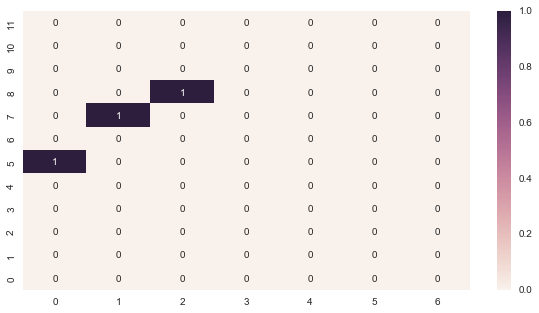

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
hm = sbn.heatmap(np.array(input_test_mix).T, annot=True, ax=ax)
hm.invert_yaxis()

In [194]:
# hack for multi-step prediction
predictions_maj_mix = []
predictions_min_mix = []
predictions_maj_avg = []
predictions_min_avg = []
predictions_mix = []
predictions_mix_warm = []
predictions_avg = []
input_test_avg = np.copy(input_test_mix)
input_test_mix_warm = np.copy(input_test_mix)
for i in range(3, len(int_min)):
    predictions_maj_avg.append(prediction_fn_maj([input_test_avg], [mask_test_mix])[0])
    predictions_min_avg.append(prediction_fn_min([input_test_avg], [mask_test_mix])[0]) 
    predictions_maj_mix.append(prediction_fn_maj([input_test_mix], [mask_test_mix])[0])
    predictions_min_mix.append(prediction_fn_min([input_test_mix], [mask_test_mix])[0]) 
    
    predictions_avg.append(.5 * (predictions_maj_avg[-1] + predictions_min_avg[-1]))
    predictions_mix_warm.append(prediction_fn_mix_warm([input_test_warm], [mask_test_mix])[0])
    predictions_mix.append(prediction_fn_mix([input_test_mix], [mask_test_mix])[0])

    p_i_avg = np.argmax(predictions_avg[-1])    
    p_i_warm = np.argmax(predictions_mix_warm[-1])
    p_i = np.argmax(predictions_mix[-1])
    
    # Alternatively, to sample from the distribution:
    # ix = np.random.choice(np.arange(vocab_size), p=probs(x).ravel())
    input_test_mix_warm[i, p_i_warm] = 1
    input_test_avg[i, p_i_avg] = 1
    input_test_mix[i, p_i] = 1
    mask_test_mix[i] = 1

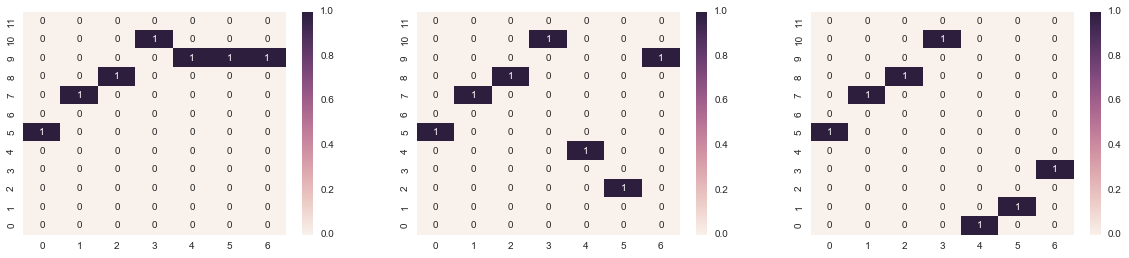

In [197]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
hm1 = sbn.heatmap(np.array(input_test_mix).T, annot=True, ax=axes[0])
hm1.invert_yaxis()
hm2 = sbn.heatmap(np.array(input_test_mix_warm).T, annot=True, ax=axes[1])
hm2.invert_yaxis()
hm3 = sbn.heatmap(np.array(input_test_avg).T, annot=True, ax=axes[2])
hm3.invert_yaxis()

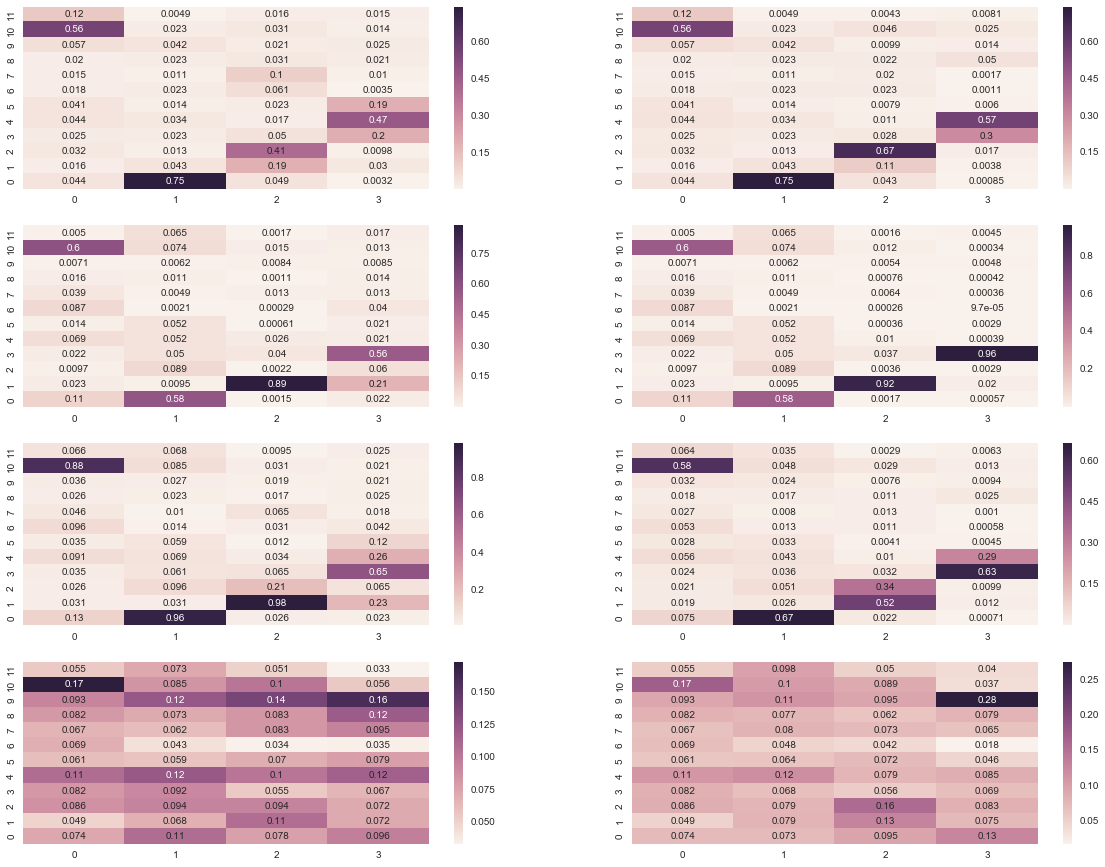

In [196]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
hm1 = sbn.heatmap(np.array(predictions_maj_mix).T, annot=True, ax=axes[0, 0])
hm1.invert_yaxis()

hm2 = sbn.heatmap(np.array(predictions_maj_avg).T, annot=True, ax=axes[0, 1])
hm2.invert_yaxis()

hm3 = sbn.heatmap(np.array(predictions_min_mix).T, annot=True, ax=axes[1, 0])
hm3.invert_yaxis()

hm4 = sbn.heatmap(np.array(predictions_min_avg).T, annot=True, ax=axes[1, 1])
hm4.invert_yaxis()

hm6 = sbn.heatmap((0.5 * np.array(predictions_maj_mix) + np.array(predictions_min_mix)).T, annot=True, ax=axes[2, 0])
hm6.invert_yaxis()

hm6 = sbn.heatmap(np.array(predictions_avg).T, annot=True, ax=axes[2, 1])
hm6.invert_yaxis()

hm7 = sbn.heatmap(np.array(predictions_mix).T, annot=True, ax=axes[3, 0])
hm7.invert_yaxis()

hm8 = sbn.heatmap(np.array(predictions_mix_warm).T, annot=True, ax=axes[3, 1])
hm8.invert_yaxis()